<a href="https://colab.research.google.com/github/MartaGacek1/MonteCarloProject1/blob/main/MonteCarloProjekt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projekt I - Wprowadzenie do symulacji i metod Monte Carlo

## Marta Gacek

## 1. Generatory liczb pseudolosowych

### 1.1 LCG ("Linear Congruential Generator")



In [4]:
# x0 - warunek początkowy
# M - wartość modulo
# a, c - parametry z rekurencyjnego wzoru
# n - ilość liczb pseudolosowych, które otrzymamy

def LCG(x0, a, c, M, n):
    result = []
    x = x0 % M
    result.append(x)
    for i in range(n-1):
        x = (a * x + c) % M
        result.append(x)
    return [j/M for j in result]

test_lcg=LCG(30, 1, 5, 13, 10)
print(test_lcg)

[0.3076923076923077, 0.6923076923076923, 0.07692307692307693, 0.46153846153846156, 0.8461538461538461, 0.23076923076923078, 0.6153846153846154, 0.0, 0.38461538461538464, 0.7692307692307693]


### 1.2 GLCG ("Generalized Linear Congruential Generator")

In [ ]:
# liczba współczynników musi być równa k, czyli liczbie wartości początkowych x_i dla i=0,...,k-1
# initials - lista k warunków początkowych
# coeffs - współczynniki a_i dla i=0,...,k-1
# M - wartość modulo
# n - ilość liczb pseudolosowych, które otrzymamy

def GLCG(initials, coeffs, M, n):
    k = len(initials)
    if len(coeffs) != k:
        raise ValueError("The number of coefficients doesn't match the number of initial values.")
    lst = initials[:] # lista "robocza"
    result = lst[:] # tutaj będą ostatecznie zwracane liczby
    result = [i/M for i in result] # normalizacja
    for i in range(n - k): # bo pierwsze k z n liczb już mamy na początku
        x = sum(coeffs[j] * lst[-(j + 1)] for j in range(k)) % M
        result.append(x/M) # normalizacja
        lst.append(x)
        lst.pop(0)  # potrzebujemy k ostatnich wartości do wyznaczania następnych x
    return result

test_glcg=GLCG([30, 40, 50], [3, 7, 68], 2**10, 10)
print(test_glcg)

[0.029296875, 0.0390625, 0.048828125, 0.412109375, 0.234375, 0.908203125, 0.388671875, 0.4609375, 0.861328125, 0.240234375]


### 1.3 RC4

[0.5, 0.5625, 0.71875, 0.625, 0.78125, 0.75, 0.15625, 0.8125, 0.125, 0.4375, 0.96875, 0.3125, 0.9375, 0.40625, 0.0625, 0.78125, 0.9375, 0.9375, 0.46875, 0.90625, 0.53125, 0.65625, 0.25, 0.84375, 0.375, 0.875, 0.1875, 0.59375, 0.59375, 0.96875, 0.71875, 0.625, 0.96875, 0.71875, 0.625, 0.75, 0.625, 0.96875, 0.9375, 0.6875, 0.6875, 0.96875, 0.9375, 0.28125, 0.0625, 0.3125, 0.59375, 0.0, 0.125, 0.0, 0.125, 0.90625, 0.75, 0.96875, 0.3125, 0.0625, 0.1875, 0.1875, 0.21875, 0.03125, 0.15625, 0.28125, 0.4375, 0.75, 0.0625, 0.71875, 0.1875, 0.25, 0.46875, 0.40625, 0.40625, 0.84375, 0.25, 0.125, 0.03125, 0.3125, 0.4375, 0.15625, 0.15625, 0.46875, 0.15625, 0.3125, 0.40625, 0.78125, 0.1875, 0.03125, 0.28125, 0.15625, 0.28125, 0.3125, 0.28125, 0.0625, 0.65625, 0.0, 0.71875, 0.5, 0.71875, 0.625, 0.4375, 0.28125, 0.09375, 0.28125, 0.59375, 0.25, 0.21875, 0.71875, 0.34375, 0.9375, 0.9375, 0.40625, 0.125, 0.125, 0.0, 0.59375, 0.84375, 0.71875, 0.34375, 0.53125, 0.21875, 0.46875, 0.6875, 0.65625, 0.625, 

(array([51., 52., 40., 41., 56., 66., 44., 49., 50., 63., 52., 49., 43.,
        48., 39., 47., 60., 56., 48., 46.]),
 array([0.00185447, 0.05175529, 0.10165612, 0.15155695, 0.20145778,
        0.25135861, 0.30125944, 0.35116027, 0.4010611 , 0.45096193,
        0.50086276, 0.55076359, 0.60066442, 0.65056525, 0.70046608,
        0.75036691, 0.80026774, 0.85016857, 0.9000694 , 0.94997023,
        0.99987106]),
 <BarContainer object of 20 artists>)

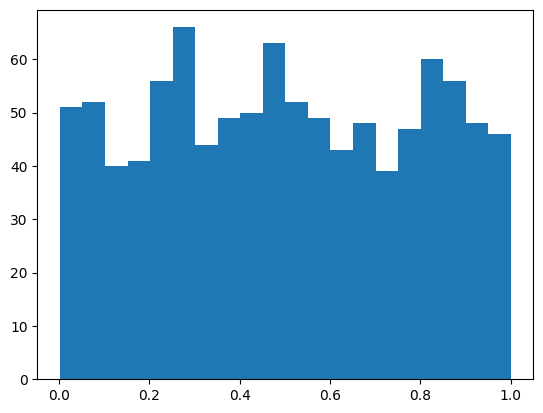

In [21]:
# K - "klucz" - liczby z przedziału {0,...,m-1}, w naszym przypadku m=32
# n - ilość liczb pseudolosowych, które otrzymamy
# S - permutacja zbioru m-elementowego
# m - wartość modulo

import matplotlib.pyplot as plt
import random as rd
import numpy as np

def KSA(K, m=32):
   S = list(range(m))
   j = 0
   for i in range(m):
       j = (j + S[i] + K[i % len(K)]) % m
       S[i], S[j] = S[j], S[i]
   return S

def PRGA(S, n, m=32):
   i = 0
   j = 0
   result = []
   for k in range(n):
       i = (i + 1) % m
       j = (j + S[i]) % m
       S[i], S[j] = S[j], S[i]
       Y = S[(S[i] + S[j]) % m]
       result.append(Y/m) # normalizacja
   return result

def RC4(K, n, m=32):
  s = KSA(K, m)
  return PRGA(s, n, m)


k1 = [x for x in range(100)]
test_rc4 = RC4(k1, 1000)
print(test_rc4)

#plt.hist(test_rc4, bins=20)
ran = np.random.uniform(size=1000)
plt.hist(ran, bins=20)

(array([67., 57., 40., 64., 26., 64., 34., 49., 30., 65., 67., 21., 75.,
        38., 68., 24., 59., 28., 56., 68.]),
 array([0.       , 0.0484375, 0.096875 , 0.1453125, 0.19375  , 0.2421875,
        0.290625 , 0.3390625, 0.3875   , 0.4359375, 0.484375 , 0.5328125,
        0.58125  , 0.6296875, 0.678125 , 0.7265625, 0.775    , 0.8234375,
        0.871875 , 0.9203125, 0.96875  ]),
 <BarContainer object of 20 artists>)

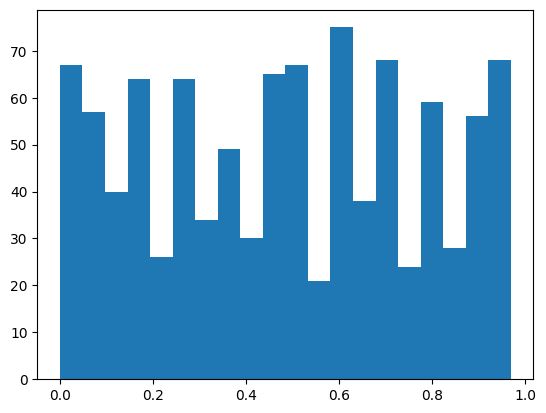

In [20]:
plt.hist(test_rc4, bins=20)

### 1.4 Xorshift

In [ ]:
# x0 - niezerowy warunek początkowy
# a, b, c - parametry określające przesunięcia bitowe
# n - ilość liczb pseudolosowych, które otrzymamy

def xorshift(x0, n, a=21, b=35, c=4):
    if x0 == 0:
        raise ValueError("Initial value must not be zero.")
    x = x0
    result = []
    for i in range(n):
        x ^= (x >> a)  # przesunięcie w prawo i operacja xor
        x ^= (x << b)  # przesunięcie w lewo i operacja xor
        x ^= (x >> c)  # przesunięcie w prawo i operacja xor
        result.append(x & 0xFFFFFFFF)  # ograniczenie liczby x do zakresu 32-bitowego
    result = [i/(2**32 - 1) for i in result] # normalizacja (dzielimy przez największą możliwą wartość wygenerowaną przez xorshift)
    return result

test_xorshift = xorshift(20, n=10)
print(test_xorshift)

[4.8894435178696745e-09, 0.12507659665427093, 0.34108384450457147, 0.3374680917098811, 0.3372721654216927, 0.09438133940435511, 0.8854625418049895, 0.19366147816033602, 0.4966507629716421, 0.5117596659138239]


# 2. Testy statystyczne